In [1]:
#경고 끄기
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='Malgun Gothic')

In [3]:
def getData():
    df2008 = pd.read_csv("C:/농수산가격데이터/1001배추/2008010120081231.csv")
    df2009 = pd.read_csv("C:/농수산가격데이터/1001배추/2009010120091231.csv")
    df2010 = pd.read_csv("C:/농수산가격데이터/1001배추/2010010120101231.csv")
    df2011 = pd.read_csv("C:/농수산가격데이터/1001배추/2011010120111231.csv")
    df2012 = pd.read_csv("C:/농수산가격데이터/1001배추/2012010120121231.csv")
    df2013 = pd.read_csv("C:/농수산가격데이터/1001배추/2013010120131231.csv")
    df2014 = pd.read_csv("C:/농수산가격데이터/1001배추/2014010120141231.csv")
    df2015 = pd.read_csv("C:/농수산가격데이터/1001배추/2015010120151231.csv")
    df2016 = pd.read_csv("C:/농수산가격데이터/1001배추/2016010120161231.csv")
    df2017 = pd.read_csv("C:/농수산가격데이터/1001배추/2017010120171231.csv")
    df2018 = pd.read_csv("C:/농수산가격데이터/1001배추/2018010120181231.csv")
    return pd.concat((df2008, df2009, df2010, df2011, df2012, df2013, df2014, df2015, df2016, df2017, df2018), axis=0)

In [4]:
def priceTransform(df):
    #Kg당 가격(priceperkg)
    #총거래가격(totalprice) = 거래량(delngQy) * 가격(sbidpric)
    #총량(totalweight) = 거래단량(delngprut) * 거래량(delngQy) * 단위

    df11 = df[(df['stdunitnewcode']==11)]
    df12 = df[(df['stdunitnewcode']==12)]
    df13 = df[(df['stdunitnewcode']==13)]
    df11['priceperkg'] = df11['sbidpric'] / df11['delngprut'] * 1000
    df11['totalweight'] = df11['delngprut'] * df11['delngqy'] / 1000
    df12['priceperkg'] = df12['sbidpric'] / df12['delngprut']
    df12['totalweight'] = df12['delngprut'] * df12['delngqy']
    df13['priceperkg'] = df13['sbidpric'] / df13['delngprut'] / 1000
    df13['totalweight'] = df13['delngprut'] * df13['delngqy'] * 1000
    
    df = pd.concat([df11, df12, df13])

    df['totalprice'] = df['sbidpric'] * df['delngqy']
        
    return df

In [5]:
df = getData()

In [6]:
df = priceTransform(df)

In [7]:
df2 = df[
    (df['aucsecode'] == 1)
    & (
        (df['stdspciesnewcode'] == 100101)
            | (df['stdspciesnewcode'] == 100102)
            | (df['stdspciesnewcode'] == 100103)
            | (df['stdspciesnewcode'] == 100104)
            | (df['stdspciesnewcode'] == 100105)
            | (df['stdspciesnewcode'] == 100106)
    )
    & (
        (df['whsalmrktcode'] == 110001)
            | (df['whsalmrktcode'] == 210001)
            | (df['whsalmrktcode'] == 220001)
      )
]

In [8]:
kamis1001 = pd.read_csv(r'C:\crop_data\1001kamis.csv')

In [9]:
kamis1001 = kamis1001.drop(columns=['Unnamed: 0'])

In [10]:
df2['priceper10kg'] = df2['priceperkg'].apply(lambda x: x*10)

In [11]:
def deleteAnomalyPrice(priceper10kg, delngde):
    if(kamis1001[kamis1001['date'] == delngde]['avg'].shape[0]):
        kamis_price = kamis1001[kamis1001['date'] == delngde]['avg'].values[0]
        if((kamis_price*0.5 <= priceper10kg) & (priceper10kg <= kamis_price*1.5)):
            return 1
    return 0

In [12]:
df2['normal'] = df2[['priceper10kg','delngde']].apply(lambda x: deleteAnomalyPrice(x['priceper10kg'], x['delngde']), axis=1)

In [13]:
df2['yyyy']   = df2['delngde'].apply(lambda x: str(x)[0:4])
df2['yyyymm'] = df2['delngde'].apply(lambda x: str(x)[0:6])
df2['delngde'] = df2['delngde'].apply(lambda x: int(x))
df2['yyyy']   = df2['yyyy'].apply(lambda x: int(x))
df2['yyyymm'] = df2['yyyymm'].apply(lambda x: int(x))
# 정렬
df2 = df2.sort_values(["delngde"], ascending=[True])

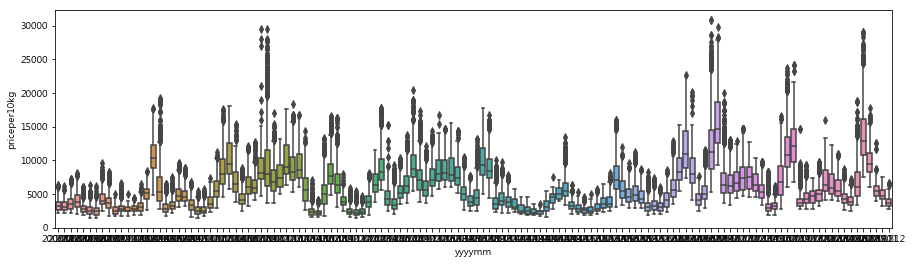

In [14]:
# 2008년 1년치 데이터 제거 후 boxplot
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='yyyymm', y='priceper10kg'
    , data=df2[
    (df2['aucsecode'] == 1)
    & (
        (df2['stdspciesnewcode'] == 100101)
            | (df2['stdspciesnewcode'] == 100102)
            | (df2['stdspciesnewcode'] == 100103)
            | (df2['stdspciesnewcode'] == 100104)
            | (df2['stdspciesnewcode'] == 100105)
            | (df2['stdspciesnewcode'] == 100106)
    )
    & (
        (df2['whsalmrktcode'] == 110001)
            | (df2['whsalmrktcode'] == 210001)
            | (df2['whsalmrktcode'] == 220001)
      )
    & (df2['normal'] == 1)
])
# ax.set_ylim([0, 3000])

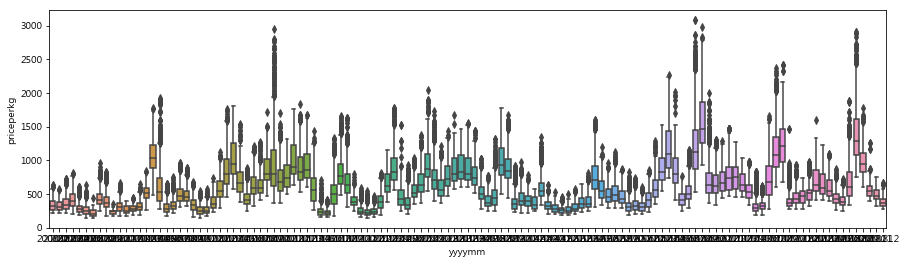

In [15]:
# 2008년 1년치 데이터 제거 후 boxplot
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='yyyymm', y='priceperkg'
    , data=df2[
    (df2['aucsecode'] == 1)
#     & ((200901 <= df2['yyyymm']) & (df2['yyyymm'] <= 200901))
    & (
        (df2['stdspciesnewcode'] == 100101)
            | (df2['stdspciesnewcode'] == 100102)
            | (df2['stdspciesnewcode'] == 100103)
            | (df2['stdspciesnewcode'] == 100104)
            | (df2['stdspciesnewcode'] == 100105)
            | (df2['stdspciesnewcode'] == 100106)
    )
    & (
        (df2['whsalmrktcode'] == 110001)
#             | (df2['whsalmrktcode'] == 210001)
#             | (df2['whsalmrktcode'] == 220001)
      )
    & (df2['normal'] == 1)
])
# ax.set_ylim([0, 3000])

In [16]:
# 원본
df[
    (df['aucsecode'] == 1)
    & (
        (df['stdspciesnewcode'] == 100101)
            | (df['stdspciesnewcode'] == 100102)
            | (df['stdspciesnewcode'] == 100103)
            | (df['stdspciesnewcode'] == 100104)
            | (df['stdspciesnewcode'] == 100105)
            | (df['stdspciesnewcode'] == 100106)
    )
    & (
        (df['whsalmrktcode'] == 110001)
            | (df['whsalmrktcode'] == 210001)
            | (df['whsalmrktcode'] == 220001)
      )
].to_csv('main.csv')

In [17]:
# 수정본
df2[
    #경매구분코드
    (df2['aucsecode'] == 1)
    #품종코드
    & (
        (df2['stdspciesnewcode'] == 100101)
            | (df2['stdspciesnewcode'] == 100102)
            | (df2['stdspciesnewcode'] == 100103)
            | (df2['stdspciesnewcode'] == 100104)
            | (df2['stdspciesnewcode'] == 100105)
            | (df2['stdspciesnewcode'] == 100106)
    )
    #시장코드
    & (
        (df2['whsalmrktcode'] == 110001)
            | (df2['whsalmrktcode'] == 210001)
            | (df2['whsalmrktcode'] == 220001)
      )
    & (df2['normal'] == 1)
].to_csv('processed.csv')